# Inferência Causal em Ação: Decifrando o Que Realmente Resolve Reclamações

Link do dataset:

https://www.kaggle.com/datasets/beatrizmsarmento/relatos-de-consumidores-do-site-consumidor-gov-br?resource=download

#### Bibliotecas utilizadas

In [54]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
import nltk
import string
import statsmodels.api as sm
from collections import Counter
from nltk.corpus import stopwords
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from scipy.stats import ttest_ind
warnings.filterwarnings("ignore")


In [12]:
# Abrir o arquivo JSON
with open("dados2025.json", "r", encoding="utf-8") as f:
    data = json.load(f)

# Normalizar os dados
df = pd.json_normalize(data)

In [50]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 203831 entries, 0 to 204030
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 203831 non-null  int64  
 1   empresa            203831 non-null  object 
 2   data               203831 non-null  object 
 3   local              203831 non-null  object 
 4   status             203831 non-null  object 
 5   relato             203831 non-null  object 
 6   resposta           203831 non-null  object 
 7   nota               203831 non-null  float64
 8   comentario         203831 non-null  object 
 9   tipo_resposta      203831 non-null  object 
 10  status_bin         203831 non-null  int32  
 11  tamanho_resposta   203831 non-null  int64  
 12  propensity_score   203831 non-null  float64
 13  tipo_resposta_bin  203831 non-null  int32  
dtypes: float64(2), int32(2), int64(2), object(8)
memory usage: 21.8+ MB
None


In [14]:
# 1. Verificar valores ausentes
missing_values = df.isnull().sum()

# 2. Criar categorias de resposta (Automática vs. Personalizada)
# Estratégia inicial: Respostas muito genéricas e curtas podem ser automáticas
df["tipo_resposta"] = np.where(df["resposta"].str.len() < 100, "Automática", "Personalizada")

# 3. Transformar "status" em variável binária
df["status_bin"] = np.where(df["status"] == "Resolvido", 1, 0)

# Exibir resumo
display(df[["resposta", "tipo_resposta", "status", "status_bin"]].head())
display(missing_values)

,resposta,tipo_resposta,status,status_bin
0,"Bom dia, Gabriel. \n\nCompreendemos o seu rela...",Personalizada,Não Resolvido,0
1,Finalizamos a sua reclamação e você pode encon...,Personalizada,Não Resolvido,0
2,"Olá, viajante! Tudo bem com você?\n\nFinalizam...",Personalizada,Não Resolvido,0
3,"Olá ,\n\nInformamos que providenciamos os devi...",Personalizada,Resolvido,1
4,"Olá, viajante! Tudo bem com você?\n\nFinalizam...",Personalizada,Não Resolvido,0


id               0
empresa          0
data             0
local            0
status           0
relato           0
resposta         0
nota             0
comentario       0
tipo_resposta    0
status_bin       0
dtype: int64

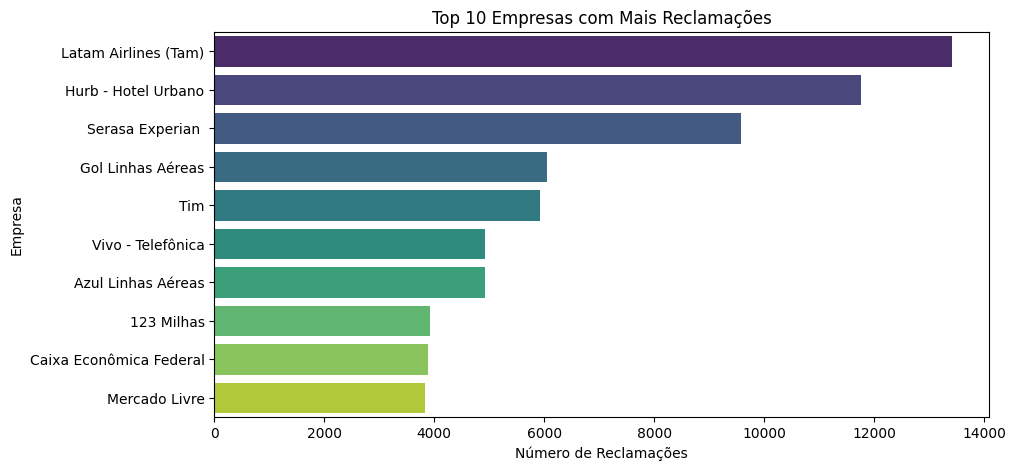

In [17]:
# Contagem de reclamações por empresa (Top 10)
top_empresas = df["empresa"].value_counts().nlargest(10)

plt.figure(figsize=(10, 5))
sns.barplot(x=top_empresas.values, y=top_empresas.index, palette="viridis")
plt.xlabel("Número de Reclamações")
plt.ylabel("Empresa")
plt.title("Top 10 Empresas com Mais Reclamações")
plt.show()

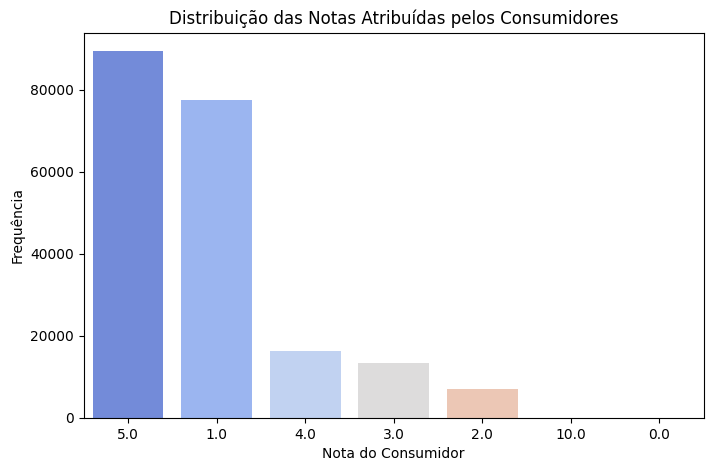

In [18]:
# Converter nota para numérica
df["nota"] = pd.to_numeric(df["nota"], errors='coerce')

# Criar gráfico de distribuição da nota
plt.figure(figsize=(8, 5))
sns.countplot(x=df["nota"], palette="coolwarm", order=df["nota"].value_counts().index)
plt.xlabel("Nota do Consumidor")
plt.ylabel("Frequência")
plt.title("Distribuição das Notas Atribuídas pelos Consumidores")
plt.show()

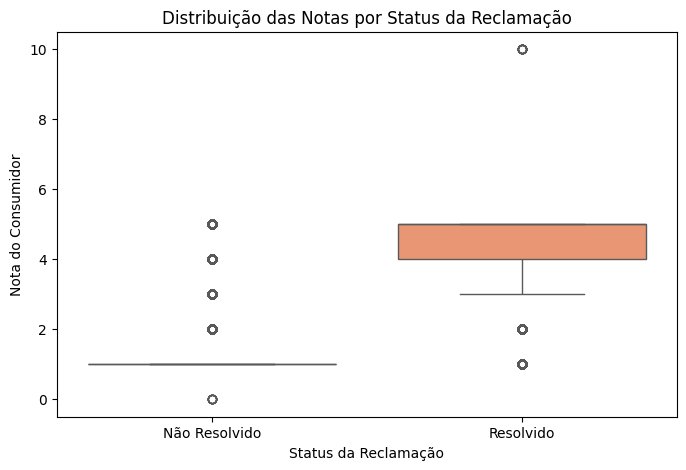

In [19]:
# Boxplot da nota por status da reclamação
plt.figure(figsize=(8, 5))
sns.boxplot(x="status_bin", y=df["nota"], data=df, palette="Set2")
plt.xticks([0, 1], ["Não Resolvido", "Resolvido"])
plt.xlabel("Status da Reclamação")
plt.ylabel("Nota do Consumidor")
plt.title("Distribuição das Notas por Status da Reclamação")
plt.show()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\51055317\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


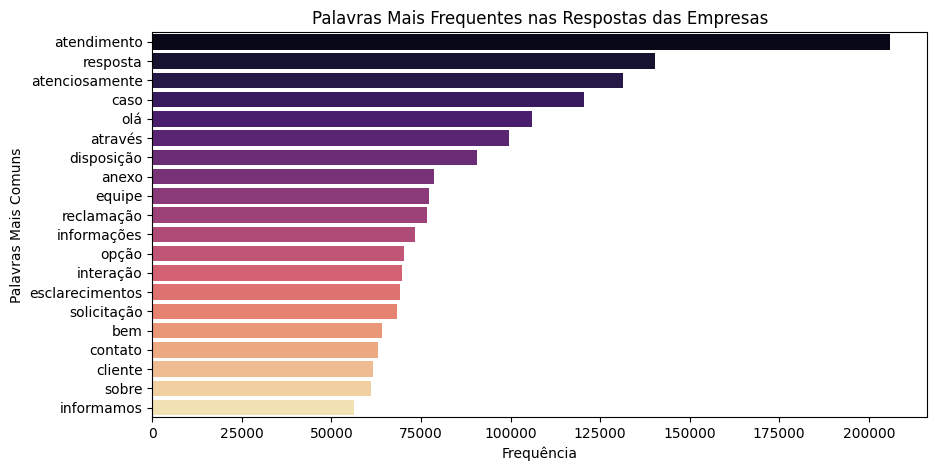

In [22]:
# Baixar stopwords em português
nltk.download('stopwords')
stopwords_pt = set(stopwords.words('portuguese'))

# Concatenar todas as respostas em um único texto
all_respostas = " ".join(df["resposta"].dropna()).lower()

# Remover pontuação e separar palavras
all_respostas = all_respostas.translate(str.maketrans('', '', string.punctuation))
words = all_respostas.split()

# Remover stopwords
words_filtered = [word for word in words if word not in stopwords_pt]

# Contar as palavras mais frequentes
word_freq = Counter(words_filtered).most_common(20)

# Criar DataFrame para visualização
word_freq_df = pd.DataFrame(word_freq, columns=["Palavra", "Frequência"])

# Criar gráfico
plt.figure(figsize=(10, 5))
sns.barplot(x="Frequência", y="Palavra", data=word_freq_df, palette="magma")
plt.xlabel("Frequência")
plt.ylabel("Palavras Mais Comuns")
plt.title("Palavras Mais Frequentes nas Respostas das Empresas")
plt.show()

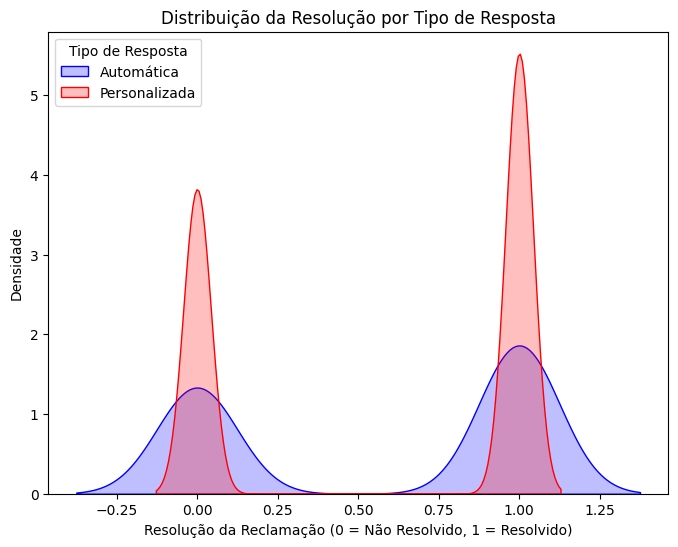

In [52]:
plt.figure(figsize=(8, 6))

# Plotando a densidade da resolução para cada tipo de resposta
sns.kdeplot(df[df["tipo_resposta"] == "Automática"]["status_bin"], fill=True, label="Automática", color="blue")
sns.kdeplot(df[df["tipo_resposta"] == "Personalizada"]["status_bin"], fill=True, label="Personalizada", color="red")

# Configurações do gráfico
plt.title("Distribuição da Resolução por Tipo de Resposta")
plt.xlabel("Resolução da Reclamação (0 = Não Resolvido, 1 = Resolvido)")
plt.ylabel("Densidade")
plt.legend(title="Tipo de Resposta")
plt.show()

#### Propensity Score

In [26]:
# Converter 'nota' para numérica, forçando erros a serem NaN
df["nota"] = pd.to_numeric(df["nota"], errors="coerce")

# Remover linhas onde a nota não é um número válido
df = df.dropna(subset=["nota"])

In [33]:
# Passo 1: Definir variáveis
X = df[["nota"]]
y = (df["tipo_resposta"] == "Automática").astype(int)  # Tratamento: 1 = Automática, 0 = Personalizada

In [34]:
# Passo 2: Criar o Propensity Score
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [35]:
# Ajustar modelo de regressão logística
log_reg = LogisticRegression()
log_reg.fit(X_train_scaled, y_train)
pscore = log_reg.predict_proba(X)[:, 1]  # Probabilidade de receber resposta automática

In [36]:
# Adicionar ao dataframe
df["propensity_score"] = pscore

# Passo 3: Emparelhamento com Propensity Score Matching (Nearest Neighbors)
df_treated = df[df["tipo_resposta"] == "Automática"]
df_control = df[df["tipo_resposta"] == "Personalizada"]

In [38]:
# Usar estatísticas para comparar antes e depois do matching
before_matching = df.groupby("tipo_resposta")["status_bin"].mean()

# Exibir resultados
before_matching.head()

tipo_resposta
Automática       0.582726
Personalizada    0.591014
Name: status_bin, dtype: float64

In [53]:
df[["propensity_score", "tipo_resposta", "status_bin"]]

,propensity_score,tipo_resposta,status_bin
0,0.004378,Personalizada,0
1,0.004378,Personalizada,0
2,0.004378,Personalizada,0
3,0.003436,Personalizada,1
4,0.004378,Personalizada,0
...,...,...,...
204026,0.003436,Personalizada,1
204027,0.004121,Personalizada,0
204028,0.003436,Personalizada,1
204029,0.003651,Personalizada,1


#### Teste de hipótese do propensity match score

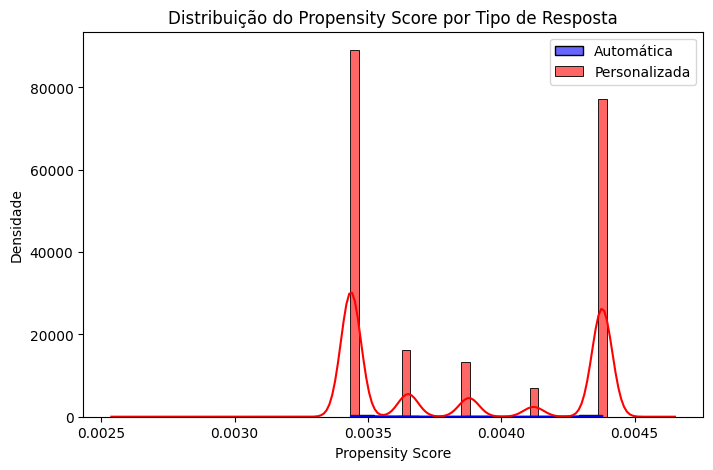

In [ ]:
# Teste de Balanceamento - Verificar se os grupos ficaram parecidos
plt.figure(figsize=(8, 5))
sns.histplot(df[df["tipo_resposta"] == "Automática"]["propensity_score"], label="Automática", kde=True, color="blue", alpha=0.6)
sns.histplot(df[df["tipo_resposta"] == "Personalizada"]["propensity_score"], label="Personalizada", kde=True, color="red", alpha=0.6)
plt.xlabel("Propensity Score")
plt.ylabel("Densidade")
plt.title("Distribuição do Propensity Score por Tipo de Resposta")
plt.legend()
plt.show()

In [ ]:
# Teste t de diferença de médias após o matching
# Pegamos apenas os dados emparelhados (PSM)
treated_psm = df[df["tipo_resposta"] == "Automática"]
control_psm = df[df["tipo_resposta"] == "Personalizada"]

In [43]:
# Teste de hipótese para diferença de médias na taxa de resolução
t_stat, p_value = ttest_ind(treated_psm["status_bin"], control_psm["status_bin"], equal_var=False)

# Exibir resultado
t_stat, p_value, treated_psm["status_bin"].mean(), control_psm["status_bin"].mean()


(-0.5195217199572587,
 0.6035156095526234,
 0.5827263267429761,
 0.5910139498200818)

#### Regressão Causal

In [45]:
# Criar a variável binária para 'tipo_resposta' (1 = Automática, 0 = Personalizada)
df["tipo_resposta_bin"] = (df["tipo_resposta"] == "Automática").astype(int)

In [47]:
# Definir variáveis explicativas corrigidas
X = df[["tipo_resposta_bin", "nota"]] 
X = sm.add_constant(X)  

y = df["status_bin"]  

# Ajustar modelo
logit_model = sm.Logit(y, X)
result = logit_model.fit()

# Exibir resultados
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.261890
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:             status_bin   No. Observations:               203831
Model:                          Logit   Df Residuals:                   203828
Method:                           MLE   Df Model:                            2
Date:                Wed, 19 Feb 2025   Pseudo R-squ.:                  0.6129
Time:                        15:01:07   Log-Likelihood:                -53381.
converged:                       True   LL-Null:                   -1.3789e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -3.7174      0.015   -240.194      0.000      -3.748      -3.687
tipo_res